# Phishing dataset
### What to test
##### For all methods:
- Metric: recall, accuracy
- holdout, cross-Validation (mean)

##### Methods:
- kNN(2-5), L1 and L2 norm
- Random forest (num trees = ???) (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier) https://mljar.com/blog/how-many-trees-in-random-forest/
 - naive bayes (https://scikit-learn.org/stable/modules/classes.html?highlight=naive%20bayes#module-sklearn.naive_bayes)
    
 ### Structure
 One function to get training + test sets depending on holdout or cross-validation <br>
 One function to train and test for all data splits for a given model <br>
     *Returns (mean) recall, accuracy for holdout/ cross-validation. <br>
     
 One cell for each method

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axis as axis
import time

import sklearn as skl
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


#load data, shuffle and separate parameters from labels
df_raw = pd.read_csv("data/phpV5QYya.csv")
num_entries = df_raw.shape[0]
num_attributes = df_raw.shape[1]
df_shuffeled = df_raw.sample(frac=1,random_state=193520285)
scaler = skl.preprocessing.MinMaxScaler()
scaler.fit(df_shuffeled)
df_shuffeled = scaler.transform(df_shuffeled)

X = df_shuffeled[:,:-1]
Y = df_shuffeled[:,-1:]

#Create splits
cross_validator10 = skl.model_selection.StratifiedKFold(n_splits=10)
hX_train, hX_test, hY_train, hY_test = skl.model_selection.train_test_split(X,Y, test_size=0.2)

0.5569425599276345


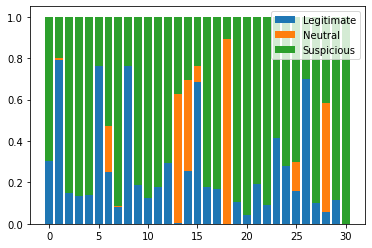

In [2]:
# Plot characteristics of data set

df_temp = df_raw[df_raw["Result"]==1]
length_df = df_temp.shape[0]

print(length_df/num_entries)

num_legitimate = np.count_nonzero(df_temp == -1, axis=0)/length_df
num_neutral    = np.count_nonzero(df_temp == 0, axis=0)/length_df
num_suspect    = np.count_nonzero(df_temp == 1, axis=0)/length_df

plt.bar(range(0,num_attributes), num_legitimate)
plt.bar(range(0,num_attributes), num_neutral, bottom = num_legitimate)
plt.bar(range(0,num_attributes), num_suspect, bottom = num_legitimate + num_neutral)

plt.legend(["Legitimate", "Neutral", "Suspicious"])

plt.savefig("ex1-plots/phishing/distribution_suspect")

## Prepare evaluation functions 

In [3]:
def evaluateModelFromDataset(model, X_train, Y_train, X_test, Y_test):
    start = time.time()
    
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    delta = (time.time()-start)/len(Y_test)*1000
    
    report = skl.metrics.classification_report(Y_test,Y_pred, output_dict=True)
    
    #Reports recall of phishing links, total accuracy and the time delta fitting and classifying took per test sample (ms)
    return report['1.0']['recall'], report['accuracy'], delta

def evaluateModel(model, do_print = True):

    #Test holdout
    holdout_rep = evaluateModelFromDataset(model, hX_train, hY_train.flatten(), hX_test, hY_test)
    
    #Test cross-evaluation
    report_recall = []
    report_accuracy  = []
    report_time = []
    for train_index, test_index in cross_validator10.split(X,Y):
        X_train = X[train_index]
        Y_train = Y[train_index]
        X_test  = X[test_index]
        Y_test  = Y[test_index]
        
        rep = evaluateModelFromDataset(model, X_train, Y_train.flatten(), X_test, Y_test)
        report_recall.append(rep[0])
        report_accuracy.append(rep[1])
        report_time.append(rep[2])
    
    if(do_print):
        print(f"Holdout recall: {holdout_rep[0]}, accuracy: {holdout_rep[1]}")
        print(f"Cross-evaluation average recall: {np.mean(report_recall)}, std: {np.std(report_recall)}")
        print(f"Cross-evaluation average accuracy: {np.mean(report_accuracy)}, std: {np.std(report_accuracy)}")
        print(f"Holdout time: {holdout_rep[2]}, cross-evaluation mean time: {np.mean(report_time)}, std: {np.std(report_time)}")
    return [holdout_rep[0], np.mean(report_recall)], [holdout_rep[1], np.mean(report_accuracy)], [holdout_rep[2], np.mean(report_time)]

## kNN

In [4]:
# perform kNN for different norms and k's

recalls = []
accuracies = []
times = []
ks = range(2,6)
for k in ks:
    kNN_L1 = kNN(n_neighbors=k, p=1)
    kNN_L2 = kNN(n_neighbors=k, p=2)
    
    print(f"-- k={k}, L1 --")
    repL1 = evaluateModel(kNN_L1)
    
    print(f"-- k={k}, L2 --")
    repL2 = evaluateModel(kNN_L2)
    
    recalls.append(repL1[0] + repL2[0])
    accuracies.append(repL1[1] + repL2[1])
    times.append(repL1[2] + repL2[2])
    
    
print("Done!")
    


-- k=2, L1 --
Holdout recall: 0.9421965317919075, accuracy: 0.9543193125282677
Cross-evaluation average recall: 0.9468886601203674, std: 0.010255963531863007
Cross-evaluation average accuracy: 0.9577572762308428, std: 0.006444423509748466
Holdout time: 0.2133096844187046, cross-evaluation mean time: 0.2469734971826622, std: 0.01276657491764248
-- k=2, L2 --
Holdout recall: 0.930635838150289, accuracy: 0.9488919041157847
Cross-evaluation average recall: 0.9325960827790096, std: 0.007208837725291052
Cross-evaluation average accuracy: 0.9498877369837906, std: 0.004833689603970898
Holdout time: 0.1570469974015752, cross-evaluation mean time: 0.16679637431883795, std: 0.010089485095736584
-- k=3, L1 --
Holdout recall: 0.9702725020644096, accuracy: 0.9561284486657621
Cross-evaluation average recall: 0.9719015943406187, std: 0.005812053769462238
Cross-evaluation average accuracy: 0.9589330922242315, std: 0.00444778876962642
Holdout time: 0.21701288244833183, cross-evaluation mean time: 0.2422

<Figure size 432x288 with 0 Axes>

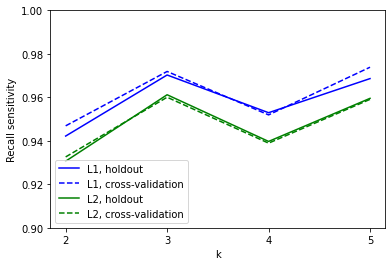

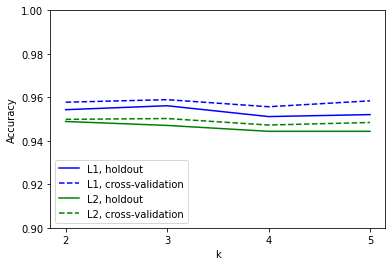

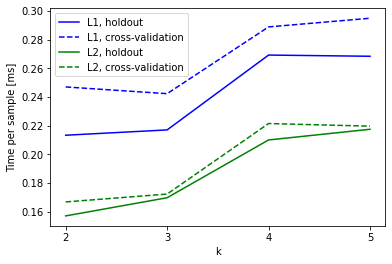

In [5]:
# plot kNN-findings

recallsT = np.transpose(recalls)
accuraciesT = np.transpose(accuracies)
timesT = np.transpose(times)

#order: holdout L1, cross L1, holdout L2, cross L2
colorScheme = ['b-','b--','g-', 'g--']
legends = ["L1, holdout", "L1, cross-validation", "L2, holdout", "L2, cross-validation"]

plt.figure(0)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(recallsT)):
    plt.plot(ks, recallsT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Recall sensitivity')
plt.legend(legends, loc = "lower left")

plt.ylim([0.9,1])

plt.savefig("ex1-plots/phishing/kNNrecall.png")

plt.figure(1)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(accuraciesT)):
    plt.plot(ks, accuraciesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(legends, loc = "lower left")
plt.ylim([0.9,1])

plt.savefig("ex1-plots/phishing/kNNaccuracy")

plt.figure(2)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(timesT)):
    plt.plot(ks, timesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Time per sample [ms]')
plt.legend(legends, loc = "upper left")

plt.savefig("ex1-plots/phishing/kNNtime")




## LDA

In [6]:
# calculate LDA
lda = LinearDiscriminantAnalysis(solver='eigen')
evaluateModel(lda)


Holdout recall: 0.953757225433526, accuracy: 0.9240162822252375
Cross-evaluation average recall: 0.9438018688628442, std: 0.010906996732279102
Cross-evaluation average accuracy: 0.9213029710423605, std: 0.004621694486023774
Holdout time: 0.020375353132961346, cross-evaluation mean time: 0.037420140392107476, std: 0.005982876077358372


([0.953757225433526, 0.9438018688628442],
 [0.9240162822252375, 0.9213029710423605],
 [0.020375353132961346, 0.037420140392107476])

In [7]:
# plot LDA

## Random forest

In [8]:
# calculate random forest for different number of forests/ different split measurements
num_trees = [1,2,4,6,8,10, 20, 50, 100, 200]

recalls = []
accuracies = []
times = []
for n in num_trees:
    
    print(f"-- Gini, Num trees: {n} --")
    randomForestGini = RandomForestClassifier(n_estimators = n, criterion="gini")
    repGini = evaluateModel(randomForestGini)
    
    print(f"-- Entropy, Num trees: {n} --")
    randomForestEntropy = RandomForestClassifier(n_estimators = n, criterion="entropy")
    repEntropy = evaluateModel(randomForestEntropy)
    
    recalls.append(repGini[0] + repEntropy[0])
    accuracies.append(repGini[1] + repEntropy[1])
    times.append(repGini[2] + repEntropy[2])
    
print("Done!")
    

-- Gini, Num trees: 1 --
Holdout recall: 0.9587118084227911, accuracy: 0.9497964721845319
Cross-evaluation average recall: 0.960691848801605, std: 0.010176182105023943
Cross-evaluation average accuracy: 0.9515149779483361, std: 0.005796421335310393
Holdout time: 0.007785428761896749, cross-evaluation mean time: 0.007641694821458727, std: 0.0013976409138763736
-- Entropy, Num trees: 1 --
Holdout recall: 0.9669694467382328, accuracy: 0.9511533242876526
Cross-evaluation average recall: 0.9579299968324358, std: 0.01179098858067813
Cross-evaluation average accuracy: 0.9524191370803434, std: 0.007769273318591929
Holdout time: 0.0036213528457565685, cross-evaluation mean time: 0.007666550279731723, std: 0.0009974885240681378
-- Gini, Num trees: 2 --
Holdout recall: 0.9273327828241124, accuracy: 0.942107643600181
Cross-evaluation average recall: 0.9426662971175166, std: 0.011278268142085017
Cross-evaluation average accuracy: 0.9535052735797338, std: 0.006202130037143982
Holdout time: 0.0060418

<Figure size 432x288 with 0 Axes>

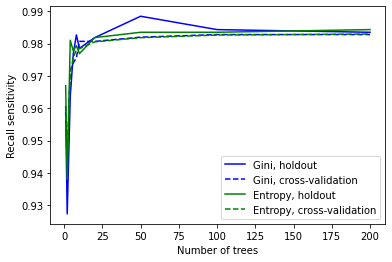

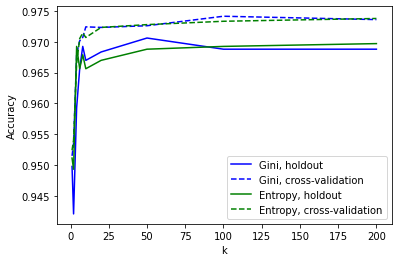

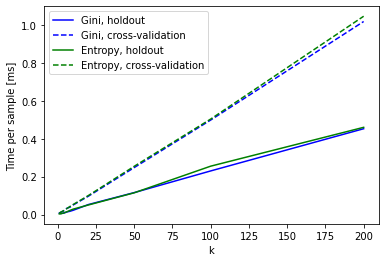

In [9]:
# plot random forest

# plot kNN-findings
recallsT = np.transpose(recalls)
accuraciesT = np.transpose(accuracies)
timesT = np.transpose(times)

#order: holdout L1, cross L1, holdout L2, cross L2
colorScheme = ['b-','b--','g-', 'g--']
legends = ["Gini, holdout", "Gini, cross-validation", "Entropy, holdout", "Entropy, cross-validation"]

plt.figure(0)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(recallsT)):
    plt.plot(num_trees, recallsT[i],colorScheme[i]) 

plt.xlabel('Number of trees')
plt.ylabel('Recall sensitivity')
plt.legend(legends, loc = "lower right")

#plt.ylim([0.96,1])

plt.savefig("ex1-plots/phishing/RandomForestSensitivity.png")

plt.figure(1)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(accuraciesT)):
    plt.plot(num_trees, accuraciesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(legends, loc = "lower right")
#plt.ylim([0.96,1])

plt.savefig("ex1-plots/phishing/RandomForestAccuracy")

plt.figure(2)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(timesT)):
    plt.plot(num_trees, timesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Time per sample [ms]')
plt.legend(legends, loc = "upper left")

plt.savefig("ex1-plots/phishing/RandomForestTime")


